## Bollinger Band Trading with GE Stock

I recently ran some simulations using Bollinger Bands as a trading strategy using Apple stock. In that analysis, this technique rarely beat the a simple buy-and-hold strategy. Given Apple's steady increase in share price since 2000 (the earliest data used), it is likely hard to beat buy-and-hold no matter what strategy is used. The overall return on APPL since 2000 is 4580.71%, which would be incredibly hard to beat if we consider a return of 10% to be good.

With that in mind, I thought it would be worthwhile to analyze a company that hasn't experienced such extraordinary returns. For this analysis, I will apply the same stragy as in my previous post [AAPL simulation](https://johnkmaxi.github.io/blog/2018/04/22/Bollinger-Band-Trading-with-Apple-Stock) to GE stock.

In [1]:
import quandl
import datetime
from bokeh.plotting import figure, output_notebook, show
# output to static HTML file
output_notebook()
import seaborn as sns
from scipy.stats import ttest_ind
 
quandl.ApiConfig.api_key = 'wesz_LiK8sqEPe6jFDqs'
 
def quandl_stocks(symbol, start_date=(2000, 1, 1), end_date=None):
    """
    symbol is a string representing a stock symbol, e.g. 'AAPL'
 
    start_date and end_date are tuples of integers representing the year, month,
    and day
 
    end_date defaults to the current date when None
    """
 
    query_list = ['WIKI' + '/' + symbol + '.' + str(k) for k in range(1, 13)]
 
    start_date = datetime.date(*start_date)
 
    if end_date:
        end_date = datetime.date(*end_date)
    else:
        end_date = datetime.date.today()
 
    return quandl.get(query_list,
            returns='pandas',
            start_date=start_date,
            end_date=end_date,
            collapse='daily',
            order='asc'
            )
data = quandl_stocks('GE')

Loading BokehJS ...

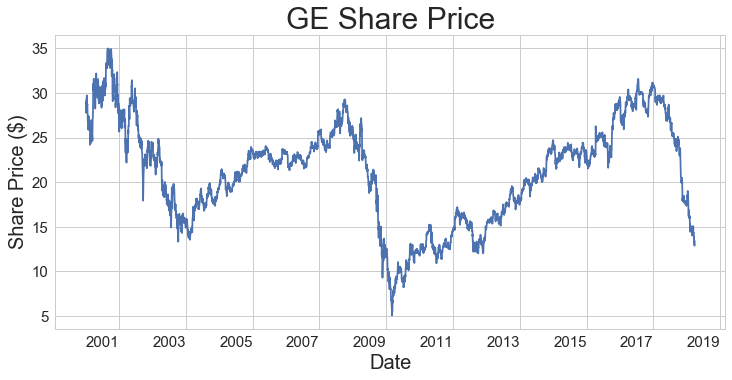

In [2]:
# use bokeh for interactive plotting
#from bokeh.plotting import figure, output_notebook, show
# output to static HTML file
#output_notebook()
# create a new plot with a title and axis labels
#p = figure(title="GE", x_axis_label='Date', y_axis_label='Balance',x_axis_type='datetime')
# add a line renderer with legend and line thickness
#p.line(data.index, data['WIKI/GE - Adj. Close'], legend="Adj. Close", line_width=2)
# show the results
#show(p)

# use matplotlib for final plots
%matplotlib inline
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
data['WIKI/GE - Adj. Close'].plot(kind='line', ax=ax,
                                         fontsize=15,
                                         rot=0)
ax.set_ylabel('Share Price ($)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('GE Share Price', fontsize=30);

In [3]:
# Cumulative return of GE
cr = ((data['WIKI/GE - Adj. Close'].iloc[-1]/data['WIKI/GE - Adj. Close'].iloc[0]) - 1)*100
print('GE cumulative return {:.2f}%'.format(cr))

GE cumulative return -53.66%


Unlike AAPL, GE has been on a downward trend since 2000, posting a cumulative return of less than -50%. Let's see if we can use Bollinger Bands or Maxi Bands to beat that number.

In [4]:
class BollingerBands:
    """A class to simulate a Bolliner Band trading strategy"""
    def __init__(self, stock, window=20, balance=3000, shares=0, sell_per=0.5, buy_amt=100, width=2, commission=10):
        self.stock = stock # daily stock price
        self.window = window # window size to compute rolling mean and Bollinger Bands
        self.start_balance = balance # starting amount of cash
        self.balance = balance # current cash balance
        self.shares = shares # shares owned
        self.commission = commission # amount I would need to pay a broker to execute the trade
        self.sell_per = sell_per # % of shares to sell on each sell signal
        self.buy_amt = buy_amt # $ amount of shares to buy on each buy signal
        self.rmean = self.stock.rolling(self.window).mean() # the rolling mean stock price
        self.upper = self.stock.rolling(self.window).mean() + width*self.stock.rolling(self.window).std() # upper band
        self.lower = self.stock.rolling(self.window).mean() - width*self.stock.rolling(self.window).std() # lower band
        self.results = pd.concat([self.stock.copy()]*4,axis=1) # create a dataframe to fill with results calculated later
        self.results.columns = ['Balance','Shares','Profit','n_shares'] # the names of the results columns
        
    def trade(self):
        # simluate the trading strategy
        for i in self.stock.index:
            if self.stock.loc[i] > self.buy_amt:
                self.buy_amt = self.buy_amt*2
            if (self.stock.loc[i] > self.upper.loc[i]) and self.shares > 0:
                # sell 50% of shares at the stock price
                profit = self.stock.loc[i] * int(self.shares*self.sell_per) # calc sell profit
                self.balance = self.balance + profit - self.commission# update balance and shares
                self.shares = int(self.shares*self.sell_per)
                self.results.loc[i,'Profit'] = profit
                #print('SELL {} shares for ${:.2f}/share = {:.2f} profit'.format(self.shares,self.stock.loc[i],profit))
            if self.stock.loc[i] < self.lower.loc[i]:
                n_shares = int(self.buy_amt/self.stock.loc[i]) # how many shares can be bought
                # make sure I can afford that many shares
                if self.balance - self.commission - (n_shares*self.stock.loc[i]) < 0:
                    n_shares = int((self.balance - self.commission)/self.stock.loc[i])
                    #print("can't buy that many shares, buy as many as you can")
                #print('BUY ${} of shares for ${:.2f}/share = {} shares acquired'.format(self.buy_amt,self.stock.loc[i],n_shares))
                if n_shares > 0:
                    self.balance = self.balance - (n_shares*self.stock.loc[i]) - self.commission
                    self.shares = self.shares + n_shares
                self.results.loc[i,'n_shares'] = n_shares
            self.results.loc[i,'Balance'] = self.balance
            self.results.loc[i,'Shares'] = self.shares
        #print(self.balance, self.shares)
        
    def buy_and_hold(self):
        # calculate the cumulative return at each point in time
        # how many shares can we buy at the beginning
        n_shares = int(self.start_balance/self.stock.iloc[0])
        # how much are those shares worth at the last time point
        buyandhold = n_shares * self.stock
        return buyandhold  

In [5]:
a = BollingerBands(data['WIKI/GE - Adj. Close'], balance=500, window=20, commission=0)
a.trade()
baseline = a.buy_and_hold()

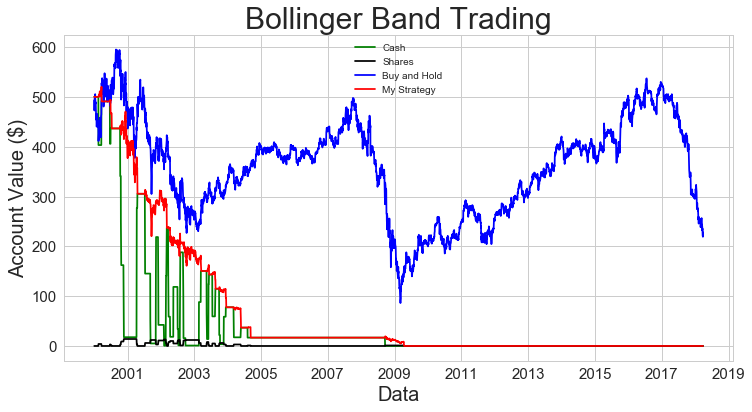

In [6]:
# create a new plot with a title and axis labels
#p = figure(title="Bollinger Bands", x_axis_label='Date', y_axis_label='Balance',x_axis_type='datetime')
# add a line renderer with legend and line thickness
#p.line(data.index, a.results['Balance'], legend="Cash", line_width=2, color='red')
#p.line(data.index, a.results['Shares'], legend="Shares", line_width=2, color='blue')
#p.line(data.index, baseline, legend="Buy and Hold", line_width=2, color='green')
#p.line(data.index, a.results['Shares']*a.stock+a.results['Balance'], legend='My Strategy', line_width=2, color='black')
#show(p)

# use matplotlib for final plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(data.index, a.results['Balance'], label='Cash', c='g')
ax.plot(data.index, a.results['Shares'], label='Shares', c='k')
ax.plot(data.index, baseline, label='Buy and Hold', c='b')
ax.plot(data.index, a.results['Shares']*a.stock+a.results['Balance'], label='My Strategy', c='r')
ax.legend()
ax.set_ylabel('Account Value ($)', fontsize=20)
ax.set_xlabel('Data', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title('Bollinger Band Trading', fontsize=30);

Similar to the initial AAPL results, my standard Bollinger Band strategy failed miserably. Let's try using the modified Maxi Bands.

In [7]:
a = BollingerBands(data['WIKI/GE - Adj. Close'], balance=500, window=6, buy_amt=250, 
                  commission=10)
a.trade()
baseline = a.buy_and_hold()

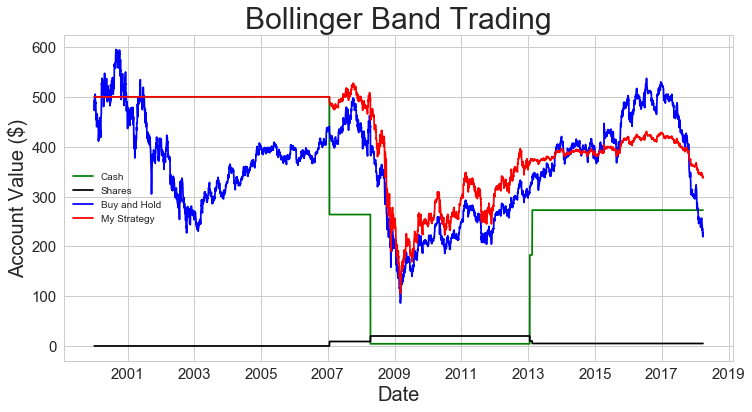

In [8]:
# create a new plot with a title and axis labels
#p = figure(title="Maxi Bands", x_axis_label='Date', y_axis_label='Balance',x_axis_type='datetime')
# add a line renderer with legend and line thickness
#p.line(data.index, a.results['Balance'], legend="Cash", line_width=2, color='red')
#p.line(data.index, a.results['Shares'], legend="Shares", line_width=2, color='blue')
#p.line(data.index, baseline, legend="Buy and Hold", line_width=2, color='green')
#p.line(data.index, a.results['Shares']*a.stock+a.results['Balance'], legend='My Strategy', line_width=2, color='black')
#show(p)

# use matplotlib for final plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(data.index, a.results['Balance'], label='Cash', c='g')
ax.plot(data.index, a.results['Shares'], label='Shares', c='k')
ax.plot(data.index, baseline, label='Buy and Hold', c='b')
ax.plot(data.index, a.results['Shares']*a.stock+a.results['Balance'], label='My Strategy', c='r')
ax.legend()
ax.set_ylabel('Account Value ($)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title('Bollinger Band Trading', fontsize=30);

In [9]:
# Cumulative return of GE
# ((((calculate return) divide by initial value) subtract 1) convert to %) take the last value
cr = ((((a.results['Shares']*a.stock+a.results['Balance'])/500) - 1) *100)[-1]
print('Maxi Bands: GE cumulative return {:.2f}%'.format(cr))

Maxi Bands: GE cumulative return -32.03%


In this case, the Maxi Bands produced a better return than market, although the still produced a negative cumulative return, -32.03%. To coninue the comparison, let's do another simulation using 100 random time frames from the GE data.

In [10]:
baseresults = []
myresults = []
for i in range(100):
    # pick to random indices to try my strategy on
    start = data['WIKI/GE - Adj. Close'].sample(1).index[0]
    end = data['WIKI/GE - Adj. Close'][start:].sample(1).index[0]
    a = BollingerBands(data['WIKI/GE - Adj. Close'].loc[start:end], balance=500, window=6, 
                       shares=0, buy_amt=250, width=2)
    a.trade()
    thisbaseline = a.buy_and_hold()
    baseresults.append(thisbaseline[-1])
    thisreturn = a.results['Shares']*a.stock+a.results['Balance']
    myresults.append(thisreturn[-1])

In [11]:
geSim = pd.DataFrame({'Base':baseresults,'Maxi':myresults})
# convert dollar returns to percentages
geSim = (geSim/500)-1 # 500 was the starting balance
# use the describe function get some basic info
geSim.describe()

,Base,Maxi
count,100.000000,100.000000
mean,0.084153,-0.093234
std,0.380803,0.149214
min,-0.682500,-0.633688
25%,-0.117650,-0.190910
50%,0.025423,0.000000
75%,0.260996,0.000000
max,1.154199,0.034161


From just eyeballing the mean and median values in the table above, the Maxi Bands were unable to beat the market on a regular basis. Interestingly, even though GE lost 50% in value between the beginning and end of the all the data, buy at a random time and selling some random time later actually produced a mean and median positive return. Even though the returns are extremely low (0.08/0.03%), I am surprised at the non-negative returns from buy-and-hold, even though the stock drops 50% overall.

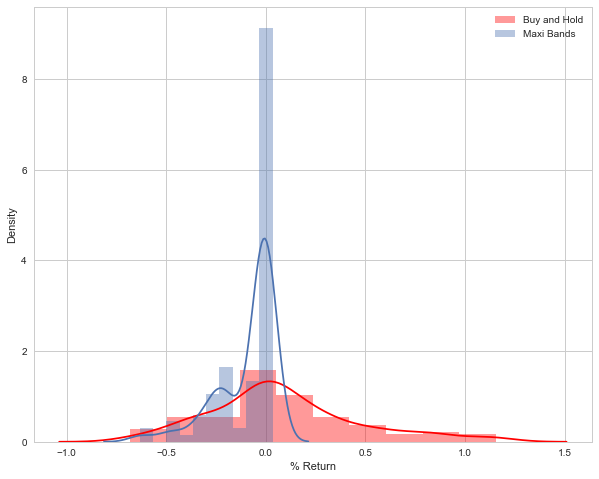

In [13]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(geSim['Base'], bins=10, color='red', label='Buy and Hold', ax=ax)
ax = sns.distplot(geSim['Maxi'], bins=10, label='Maxi Bands', axlabel='% Return')
ax.set_ylabel('Density')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

In [14]:
from scipy.stats import ttest_ind
ttest_ind(geSim['Base'], geSim['Maxi'])

Ttest_indResult(statistic=4.3371472227335621, pvalue=2.2976376788774939e-05)

The shape of the histograms show some interesting patterns. The buy-and-hold strategy has a wide distribution around 0. This strategy is just as likely to post negative returns as positive returns. Meanwhile, the Maxi Strategy almost never generates a positive return (the max return value is 0.03%), but those values are clustered right around 0. On average, you would expect to break even. Quantitatively, the return of the buy-and-hold strategy is significanlty different than my strategy.

In [15]:
(geSim['Maxi']>geSim['Base']).sum()

32

Surprisingly, 32% of the time my strategy beats the buy-and-hold strategy. This is better than the proportion when testing AAPL (~20%). This confirms what the descriptive statistics and histogram indicate - that it is more likely to get better returns with buy-and-hold for any random time frame.

median:  -0.09987475889635106
mean:  -0.177386590375


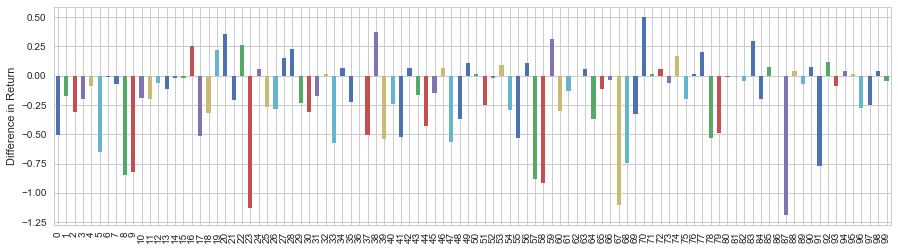

In [16]:
fig, ax = plt.subplots(figsize=(15,4))
(geSim['Maxi']-geSim['Base']).plot(kind='bar', ax=ax)
ax.set_ylabel('Difference in Return');
print('median: ', (geSim['Maxi']-geSim['Base']).median())
print('mean: ', (geSim['Maxi']-geSim['Base']).mean())

When my strategy does beat the market, it is not by much. And when it loses, the difference tends be sizable (median = -0.048%, mean = -0.148%).

### Conclusion
- My stategy does not work for trading GE stock, a downward trending stock.
- The return is typically 0.048% less
- The largest returns are possible using a buy-and-hold strategy, 0.07% return on average

### Future Work
The results of the simlated trading strategy are dependent on several hyperparameters including the size of window used for rolling mean calculations, the percentage of shares to sell at a time, how much money to use at each buy signal, and the number of standard deviations used to set the upper and lower bounds. In my next post, I will implement an algorithm that optimizes these hyperparameters in order to maximize the return on investment for a particular stock. Be sure to check it out!